# Testing the non-Markovian Path Analysis Package

We are going to generate first a MC trajectory of a toy model 

In [79]:
import numpy as np
from math import pi,sin,exp
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.interpolate
import matplotlib.cm as cm

from NMpathAnalysis.nmtools.interval import Interval
from NMpathAnalysis.nmtools.functions import *
from NMpathAnalysis.src.ensemble import *

In [80]:
def energy(x,y):
    if (x > 6*pi) or (x < 0) or (y > 6*pi) or (y < 0):
        return 10**10
    else:
        ener = 1.5*(1 - sin(x) * sin(y)) + 0.0009*(((x - (9 * sin(y/3) + y))**2) * (y - (9*sin(x/3) + x))**2)
        return ener

In [134]:
def plot_traj(list_of_trajs, discrete=[False],color='k',line_width=0.5):

    xlist = np.linspace(0,6*pi)
    ylist = np.linspace(0,6*pi)
    X,Y = np.meshgrid(xlist, ylist)

    Z = np.array([[energy(X[i,j],Y[i,j]) for i in range(len(X))] for j in range(len(X))])

    plt.figure(figsize=(8,6.5))

    #im = plt.imshow(Z,interpolation='bilinear',vmin = -5,vmax =5,cmap=cm.Spectral,alpha=0.5)
    #plt.colorbar(im)

    levels = list(np.arange(0, 10, 0.2))
    plt.contourf(X, Y, Z,levels,linestyles = 'solid',cmap=cm.jet, alpha =0.7)
    
    for i,element in enumerate(list_of_trajs):
        if not discrete[i]:
            plt.plot(element[0],element[1],color=color,linewidth=line_width)
        else:
            xi = np.array(element[0])
            x_values = [pi*(int(element/6)+0.5+np.random.normal(0,0.1)) for element in xi]
            y_values = [pi*(element%6+0.5+np.random.normal(0,0.1)) for element in xi]
            plt.plot(x_values,y_values,color=color,linewidth=line_width)


    plt.axis([0, 6*pi, 0, 6*pi])
    plt.yticks([i*pi for i in range(7)],[' ','$\pi$','$2\pi$','$3\pi$','$4\pi$','$5\pi$','$6\pi$'],fontsize = 15)
    plt.xticks([i*pi for i in range(7)],['0','$\pi$','$2\pi$','$3\pi$','$4\pi$','$5\pi$','$6\pi$'],fontsize = 15)
    plt.xlabel('X', fontsize = 13)
    plt.ylabel('Y', fontsize = 13)

    plt.grid(linewidth = 1,linestyle='--',alpha=0.6)

    plt.colorbar()
    plt.show() 


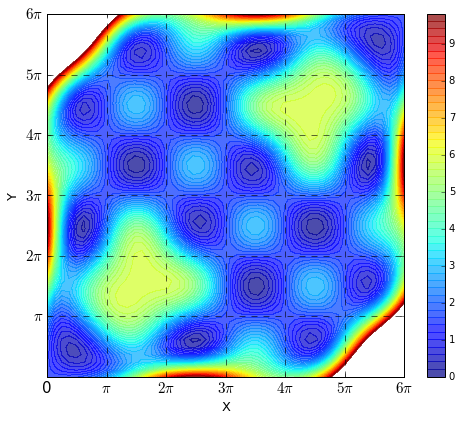

In [123]:
plot_traj([],[])

In [112]:
'''
MC simulation
'''
def mc_simulation2D(numsteps):
    x = 1; y = 1
    mc_traj = []
    
    for i in range(numsteps):
        dx = np.random.uniform(-pi,pi)
        dy = np.random.uniform(-pi,pi)
        if (np.random.random() < exp(-(energy(x+dx,y+dy)-energy(x,y))) ):
            x = x + dx; y = y + dy
        mc_traj += [[x,y]]
        

    return np.array(mc_traj)

In [113]:
'''
Simple mapping funcion 
'''
def mapping_function2D(vector2D):
    x = vector2D[0]
    y = vector2D[1]
    return 6*int(x/pi)+int(y/pi)

In [85]:
#Generating a short MC trajectoy
mc_traj_2d = mc_simulation2D(100000)



## 1- Ensemble class (analysis of continuos trajectories)

Stores an esemble (list) of trajectories (array) with extra functionalities. The ensemble could have a any number of trajectories including no trajectories at all.

### Adding trajectories to the Ensemble
New trajectories can be added to the ensemble as long as there is consistency in the number of variables.

In [86]:
my_ensemble = Ensemble(mc_traj_2d)

#my_ensemble = Ensemble()
#my_ensemble.add_trajectory(mc_traj_2d)

In [87]:
n_states = 36
C1 = my_ensemble._count_matrix(n_states, mapping_function2D)
print(C1)

[[ 4451.    76.     0. ...,     0.     0.     0.]
 [   76.   459.    59. ...,     0.     0.     0.]
 [    0.    55.  3364. ...,     0.     0.     0.]
 ..., 
 [    0.     0.     0. ...,  3719.    82.     0.]
 [    0.     0.     0. ...,    85.   726.   128.]
 [    0.     0.     0. ...,     0.   134.  8755.]]


In [88]:
K1 = my_ensemble._mle_transition_matrix(n_states, mapping_function2D)
print(K1)

[[ 0.96425477  0.01646447  0.         ...,  0.          0.          0.        ]
 [ 0.12199037  0.73675762  0.09470305 ...,  0.          0.          0.        ]
 [ 0.          0.01433785  0.87695516 ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ...,  0.86851938  0.01914993  0.        ]
 [ 0.          0.          0.         ...,  0.085       0.726       0.128     ]
 [ 0.          0.          0.         ...,  0.          0.01485752
   0.97072846]]


### Defining states and computing MFPTs
The states are considered intervals in the is the class is Ensemble

In [89]:
stateA = [[0,pi],[0,pi]]
stateB = [[5*pi,6*pi],[5*pi,6*pi]]

my_ensemble.mfpts(stateA, stateB)

{'mfptAB': 1243.3225806451612,
 'mfptBA': 2042.2333333333333,
 'std_err_mfptAB': 192.7450931694195,
 'std_err_mfptBA': 300.78114111734442}

### Adding more trajectories to the ensemble or (ensemble + ensemble)

In [90]:
seq1 = mc_simulation2D(20000)
seq2 = mc_simulation2D(20000)

my_e1 = Ensemble(seq1)
my_e2 = Ensemble(seq2)

ensemble1 = my_e1 + my_e2


In [91]:
ensemble1.mfpts(stateA,stateB)

{'mfptAB': 1952.2727272727273,
 'mfptBA': 1269.0,
 'std_err_mfptAB': 549.19174406628099,
 'std_err_mfptBA': 267.11349647668493}

In [92]:
e1 = Ensemble([1,2,3,4])
e2 = Ensemble([2,3,4,5])
e3 = Ensemble([2,1,1,4])

my_ensembles = [e1, e2, e3]

ensemble_tot = Ensemble([])

for ens in my_ensembles:
    ensemble_tot += ens

ensemble_tot.trajectories
ensemble_tot.mfpts([1,1],[4,4])

{'mfptAB': 2.5,
 'mfptBA': 'NaN',
 'std_err_mfptAB': 0.35355339059327373,
 'std_err_mfptBA': 'NaN'}


## 2- DiscreteEnsemble class

We can generate a discrete trajectory from the same mapping function and we should obtain exaclty the same result:

In [93]:
d_ens = DiscreteEnsemble.from_ensemble( mc_traj_2d, mapping_function2D)

In [94]:
C2 = d_ens._count_matrix(n_states)
print(C2)

[[ 4451.    76.     0. ...,     0.     0.     0.]
 [   76.   459.    59. ...,     0.     0.     0.]
 [    0.    55.  3364. ...,     0.     0.     0.]
 ..., 
 [    0.     0.     0. ...,  3719.    82.     0.]
 [    0.     0.     0. ...,    85.   726.   128.]
 [    0.     0.     0. ...,     0.   134.  8755.]]


In [95]:
K2= d_ens._mle_transition_matrix(n_states)
print(K2)

[[ 0.96425477  0.01646447  0.         ...,  0.          0.          0.        ]
 [ 0.12199037  0.73675762  0.09470305 ...,  0.          0.          0.        ]
 [ 0.          0.01433785  0.87695516 ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ...,  0.86851938  0.01914993  0.        ]
 [ 0.          0.          0.         ...,  0.085       0.726       0.128     ]
 [ 0.          0.          0.         ...,  0.          0.01485752
   0.97072846]]


### Defining states and computing MFPTs
The states are now considered sets, defining the states as follow we should obtain the same results

In [96]:
stateA = [0]
stateB = [35]

d_ens.mfpts(stateA, stateB)

{'mfptAB': 1243.3225806451612,
 'mfptBA': 2042.2333333333333,
 'std_err_mfptAB': 192.7450931694195,
 'std_err_mfptBA': 300.78114111734442}

### Generating trajectories from the transition matrix

In [97]:
d_ens2 = DiscreteEnsemble.from_transition_matrix(K2, sim_length = 100000)

In [98]:
d_ens2.mfpts(stateA,stateB)

{'mfptAB': 925.3863636363636,
 'mfptBA': 1312.0,
 'std_err_mfptAB': 113.87084542551976,
 'std_err_mfptBA': 201.4131146886792}

## 3 - DiscretePathEnsemble

In [170]:
pathEnsemble = DiscretePathEnsemble.from_transition_matrix(K2,stateA, stateB, n_paths = 100,ini_pops = [1])

In [171]:
FSs = pathEnsemble.fundamental_sequences(K2)
size = len(FSs)

paths = pathEnsemble.trajectories

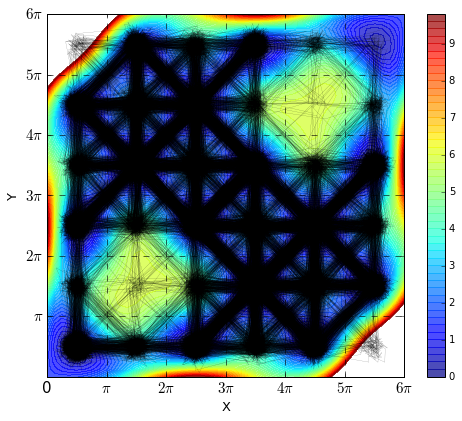

In [179]:
plot_traj([[paths[i],[]] for i in range(size)] ,discrete=[True for i in range(size)],line_width=0.1)

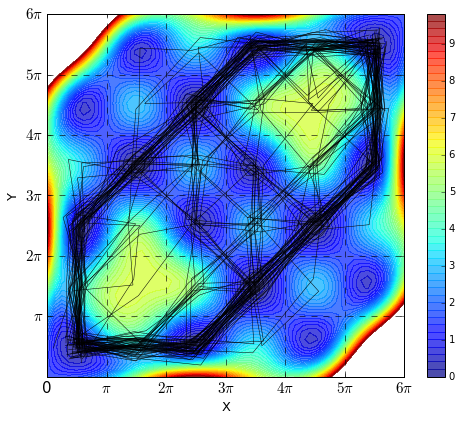

In [180]:
plot_traj([[FSs[i],[]] for i in range(size)] ,discrete=[True for i in range(size)],line_width=0.5)